Epoch 0/50
Batch 0 / 157 Loss 0.1923193782567978
Batch 100 / 157 Loss 0.10992919653654099
EVAL Batch 0 / 157 Loss 0.09611808508634567
EVAL Batch 100 / 157 Loss 0.09741059690713882
Epoch 1/50
Batch 0 / 157 Loss 0.09611808508634567
Batch 100 / 157 Loss 0.08188845217227936
EVAL Batch 0 / 157 Loss 0.06898324936628342
EVAL Batch 100 / 157 Loss 0.06952618807554245
Epoch 2/50
Batch 0 / 157 Loss 0.06898324936628342
Batch 100 / 157 Loss 0.06490764021873474
EVAL Batch 0 / 157 Loss 0.06478356570005417
EVAL Batch 100 / 157 Loss 0.06728773564100266
Epoch 3/50
Batch 0 / 157 Loss 0.06478356570005417
Batch 100 / 157 Loss 0.08570201694965363
EVAL Batch 0 / 157 Loss 0.08845904469490051
EVAL Batch 100 / 157 Loss 0.0892622098326683
Epoch 4/50
Batch 0 / 157 Loss 0.08845904469490051
Batch 100 / 157 Loss 0.08907715231180191
EVAL Batch 0 / 157 Loss 0.08836830407381058
EVAL Batch 100 / 157 Loss 0.08915320783853531
Epoch 5/50
Batch 0 / 157 Loss 0.08836830407381058
Batch 100 / 157 Loss 0.08900928497314453
EVAL B

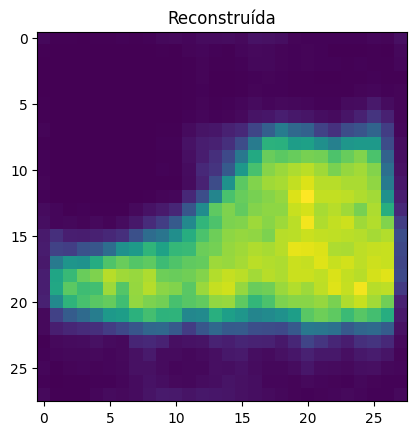

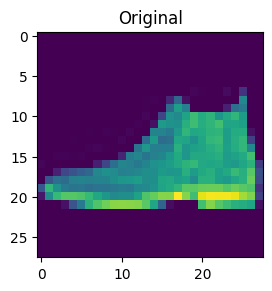

In [1]:
import torch 
from torch import nn
from torchvision import datasets 
from torch.utils.data import DataLoader 
from torchvision.transforms import ToTensor, Lambda 
import matplotlib.pyplot as plt 
import torchvision

from quantizer import VectorQuantizer


train_dataset = datasets.FashionMNIST(
    root = 'data',
    train = False,
    transform=ToTensor(),
    download = True 
)

test_dataset = datasets.FashionMNIST(
    root = 'data',
    train = False,
    download = True,
    transform = ToTensor()
)

train_dataloader = DataLoader(train_dataset, batch_size = 64)

test_dataloader = DataLoader(test_dataset, batch_size = 64) 

class Encoder(nn.Module):
    def __init__(self, hid_dim = 64, feat_dim = 128, CHANNELS = 1):
        super().__init__()
        self.hid_dim = hid_dim 
        self.feat_dim = feat_dim 
        self.encoder_stack = nn.Sequential(
            nn.Conv2d(CHANNELS, hid_dim, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(hid_dim, hid_dim, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(hid_dim, feat_dim, 1),
            nn.ReLU()
        )

    def forward(self, x):
        
        return self.encoder_stack(x) #(bs, feat_dim, h, w)

class Decoder(nn.Module):
    def __init__(self, hid_dim = 64, feat_dim = 128, CHANNELS = 1):
        super().__init__()
        self.hid_dim = hid_dim 
        self.feat_dim = feat_dim 
        self.decoder_stack = nn.Sequential(
            nn.ConvTranspose2d(feat_dim, hid_dim, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(hid_dim, hid_dim, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(hid_dim, CHANNELS, 4, 2, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder_stack(x)

class VQVAE(nn.Module):
    def __init__(self, encoder, decoder, commitment_cost, num_embeddings, quantizer):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder 
        self.quantizer = quantizer 
        self.commitment_cost = commitment_cost
        self.num_embeddings = num_embeddings

    def forward(self, x):
        z = self.encoder(x)
        quantized = self.quantizer(z)
        quantized = quantized.view(-1, self.encoder.feat_dim, z.shape[2], z.shape[3])
        x_recon = self.decoder(quantized)

        return x_recon


def train_step(dataloader, model, optimizer, loss_fn, device = 'cuda'):
    model.train()
    total = len(dataloader)
    for idx, (data, _) in enumerate(dataloader):
        data = data.to(device)
        optimizer.zero_grad()
        recon = model(data)
        loss = loss_fn(recon, data)
        loss.backward()
        optimizer.step()

        if idx % 100 == 0:
            print(f'Batch {idx} / {total} Loss {loss.item()}')

def test_step(dataloader, model, loss_fn, device = 'cuda'):
    model.eval()
    total = len(dataloader)
    with torch.no_grad():
        for idx, (data, _) in enumerate(dataloader):
            data = data.to(device)
            recon = model(data)
            loss = loss_fn(recon, data)
            if idx % 100 == 0:
                print(f'EVAL Batch {idx} / {total} Loss {loss.item()}')


encoder = Encoder().to('cuda')
decoder = Decoder().to('cuda')
quantizer = VectorQuantizer(512, 128, 0.25).to('cuda')
model = VQVAE(encoder, decoder, 0.25, 512, quantizer).to('cuda')
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)
loss_fn = nn.MSELoss()
EPOCHS = 50

for epoch in range(EPOCHS):
    print(f'Epoch {epoch}/{EPOCHS}')
    train_step(train_dataloader, model, optimizer, loss_fn)
    test_step(test_dataloader, model, loss_fn)

encoded = model.encoder(test_dataset[0][0].unsqueeze(0).to('cuda'))
quantized = model.quantizer(encoded)
quantized = quantized.view(-1, model.encoder.feat_dim, encoded.shape[2], encoded.shape[3])
recon = model.decoder(quantized)
print(recon.shape)  # torch.Size([1, 1, 28, 28])

recon = recon.squeeze().cpu().detach().numpy()

# Exibir a imagem
plt.imshow(recon, cmap='gray' if recon.shape[-1] == 1 else None)
plt.title("Reconstruída")
plt.show()

plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(test_dataset[0][0].numpy().transpose(1, 2, 0))
plt.show()


